# SMA for Russia-Ukraine Conflict

# Install and Import Required Packages

In [ ]:
# Geocoding
!pip install geopandas
!pip install geopy
!pip install pycountry

# Sentiment
!pip install vaderSentiment

!pip install spacy

!pip install tweepy
!pip install wordcloud

# Visualise topics
!pip install pyldavis

# Update gensim to latest 
!pip install -U gensim

In [ ]:
import re
import tweepy
import pandas as pd
import numpy as np
np.random.seed(1409) # Reproducibility

import matplotlib.pyplot as plt
import plotly.express as px

import csv
import math

import geopandas as gpd
import geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

import folium
from folium.plugins import FastMarkerCluster

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pycountry

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

# Twitter API

## Twitter API Configuration

In [ ]:
# Twitter API authentication handler
CONSUMER_KEY = ""
CONSUMER_SECRET = ""
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)

KEY = ""
SECRET = ""
auth.set_access_token(KEY, SECRET)

# API interface
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Verify crendentials
try:
  api.verify_credentials()
  print("[SUCCESS] API Authentication OK")
except:
  print("[ERROR] API Authentication ERROR")

[SUCCESS] API Authentication OK


### Downloading of new data set
**[IMPORTANT]** Do not run the cell below unless intending to download a new `current_set.csv` dataset.

In [ ]:
# Collect tweets
query = "russia ukraine -filter:retweets"
cutoff_date = "2022-02-23"
NUM_TWEETS = 2000
tweets = tweepy.Cursor(api.search, q=query, lang="en", since=cutoff_date, result_type="mixed", tweet_mode="extended").items(NUM_TWEETS)

tweets_list = [[tweet.created_at,
                tweet.user.screen_name,
                tweet.user.location,
                tweet.full_text] for tweet in tweets]

tweets_df = pd.DataFrame(data=tweets_list, columns=["date", "user", "location", "text"])

# Save retrieved tweets as CSV file
tweets_df.to_csv("current_set.csv", quotechar='"', encoding="utf8", index = False, header=True)

## Geocoding
**[IMPORTANT]** Do not run the cell below unless intending to geocode new `current_set_geo.csv` dataset.
- **Warning** it takes some time for location parsing.
  - 1000 tweets = 16.7 min (***aprox***)
  - Use the provided "***current_set_geo.csv***" file
- Note that parse error may show for some input.

In [ ]:
# Load extracted tweets set
tweets_df = pd.read_csv("current_set.csv", quotechar='"', encoding="utf8")

# Remove tweets with unkown location
tweets_df = tweets_df.dropna(subset=["location"])

# Geocode API with delay to prevent access block due to too many requests
locator = Nominatim(user_agent="Armandas_SMA_CW2")
try:
  geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
  tweets_df["location_processed"] = tweets_df["location"].apply(geocode)
except GeocoderTimedOut as e:
  print(f"[ERROR] Geocode failed to parse an input {e.message}")

# Get latitude, longitude and altitude
tweets_df["point"] = tweets_df["location_processed"].apply(lambda loc: tuple(loc.point) if loc else None)
tweets_df[["lat", "long", "alt"]] = pd.DataFrame(tweets_df["point"].tolist(), index=tweets_df.index)

# Save processed tweets as CSV file
tweets_df.to_csv("current_set_geo.csv", quotechar='"', encoding="utf8", index = False, header=True)

# Data Preprocessing
Preprocess `current_set_geo.csv` dataset for geo sentiment analysis.

In [ ]:
# Load extracted tweets set
tweets_df = pd.read_csv("current_set_geo.csv", quotechar='"', encoding="utf8")

# Remove links
tweets_df["text_processed"] = tweets_df["text"].map(lambda x: re.sub(r"http\S+", "", x))

# Remove usernames
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"@[^\s]+", "", x))

# Convert &amp to &
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"&amp;", "&", x))

# Remove &gt and &lt (HTML symbols for '>' and '<')
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"&[gl]t;", "", x))

# Remove punctuation
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"[\.,!?:]", "", x))
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"[=|—#]", " ", x))

# Remove unnecessary line breaks
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"\n", "", x))

# Lowercase text
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: x.lower())

# Remove emoji
emoji_ptrn = re.compile(pattern="["
                        u"\U0001F600-\U0001F64F" # emoticons
                        u"\U0001F300-\U0001F5FF" # symbols & pictographs
                        u"\U0001F680-\U0001F6FF" # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF" # flags
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: emoji_ptrn.sub(r"", x))

# Remove leading, trailing, and replace inner spaces
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub("[\t ]+", " ", x).strip())

# Drop duplicates and keep first occurrence
tweets_df = tweets_df.drop_duplicates(subset=["text_processed"], keep="first")

# Conv to string
tweets_df["text_processed"] = tweets_df["text_processed"].astype(str)

# Remove 's
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"[‘’']s","",x))

In [ ]:
tweets_df.head()

,date,user,location,text,location_processed,point,lat,long,alt,text_processed
0,2022-03-27 21:38:40,JuliaDavisNews,United States,Russian media is suddenly explicit about what ...,United States,"(39.7837304, -100.445882, 0.0)",39.783730,-100.445882,0.0,russian media is suddenly explicit about what ...
1,2022-03-27 11:46:29,IAPonomarenko,"Kyiv, Ukraine",The streets of Mariupol is just one giant ceme...,"Київ, 1001, Україна","(50.4500336, 30.5241361, 0.0)",50.450034,30.524136,0.0,the streets of mariupol is just one giant ceme...
2,2022-03-27 11:57:21,DmytroKuleba,Київ,"Apparently, job losses in Russia are more impo...","Київ, 1001, Україна","(50.4500336, 30.5241361, 0.0)",50.450034,30.524136,0.0,apparently job losses in russia are more impor...
3,2022-03-28 19:06:03,baladorje,"Somerset, United Kingdom",#Ukraine #Russia Putin Taking Over Donbas From...,"Somerset, England, United Kingdom","(51.161750850000004, -3.0753867062227487, 0.0)",51.161751,-3.075387,0.0,ukraine russia putin taking over donbas from u...
4,2022-03-28 19:06:02,PolitomixNews,"Philadelphia, PA USA",Exiled Belarus opposition leader discusses Rus...,"H.E.L.P. USA, Grovers Avenue, Elmwood Park, Ph...","(39.9116647, -75.2357076675119, 0.0)",39.911665,-75.235708,0.0,exiled belarus opposition leader discusses rus...


## Exploratory Analysis
Build a wordcloud to verify if further preprocessing is necessary.

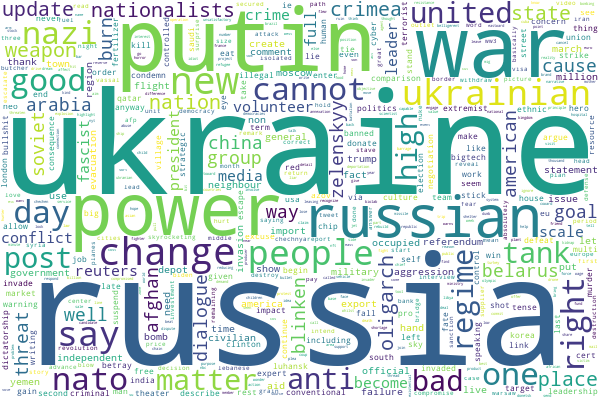

In [ ]:
# Extract Processed tweets
tweets_processed = [str(x) for x in tweets_df["text_processed"]]

# join the words of the different tweets together into one string
long_string = ' '.join(tweets_processed)
new_long_string = ' '.join(set(long_string.split(" ")))

# Stop words
stop_words = stopwords.words("english")
stop_words.extend(["us", "re"])

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=800, contour_width=3, contour_color='steelblue',
                      width=600, height=400, stopwords=stop_words)

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## General Sentiment Analysis
Sentiment analysis based on the lexicon and rule-based [VADER](https://github.com/cjhutto/vaderSentiment) sentiment analysis tool.

In [ ]:
# Remove tweets with unkown location
tweets_unk_df = tweets_df.dropna(subset=["location", "lat", "long"])

# Sentiment Analysis
analyser = SentimentIntensityAnalyzer()
tweets_unk_df["sentiment"] = tweets_unk_df["text_processed"].apply(lambda tweet:
                                                analyser.polarity_scores(tweet))

# Extract compound score
tweets_unk_df["compound"] = tweets_unk_df["sentiment"].apply(lambda sentiment:
                                                sentiment["compound"])

# Print dataset
tweets_unk_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,user,location,text,location_processed,point,lat,long,alt,text_processed,sentiment,compound
0,2022-03-27 21:38:40,JuliaDavisNews,United States,Russian media is suddenly explicit about what ...,United States,"(39.7837304, -100.445882, 0.0)",39.783730,-100.445882,0.0,russian media is suddenly explicit about what ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,2022-03-27 11:46:29,IAPonomarenko,"Kyiv, Ukraine",The streets of Mariupol is just one giant ceme...,"Київ, 1001, Україна","(50.4500336, 30.5241361, 0.0)",50.450034,30.524136,0.0,the streets of mariupol is just one giant ceme...,"{'neg': 0.062, 'neu': 0.807, 'pos': 0.132, 'co...",0.5095
2,2022-03-27 11:57:21,DmytroKuleba,Київ,"Apparently, job losses in Russia are more impo...","Київ, 1001, Україна","(50.4500336, 30.5241361, 0.0)",50.450034,30.524136,0.0,apparently job losses in russia are more impor...,"{'neg': 0.337, 'neu': 0.62, 'pos': 0.043, 'com...",-0.9218
3,2022-03-28 19:06:03,baladorje,"Somerset, United Kingdom",#Ukraine #Russia Putin Taking Over Donbas From...,"Somerset, England, United Kingdom","(51.161750850000004, -3.0753867062227487, 0.0)",51.161751,-3.075387,0.0,ukraine russia putin taking over donbas from u...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,2022-03-28 19:06:02,PolitomixNews,"Philadelphia, PA USA",Exiled Belarus opposition leader discusses Rus...,"H.E.L.P. USA, Grovers Avenue, Elmwood Park, Ph...","(39.9116647, -75.2357076675119, 0.0)",39.911665,-75.235708,0.0,exiled belarus opposition leader discusses rus...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


Build sentiment geolocation map of the processed tweets.

In [ ]:
# Build map
map = folium.Map(tiles="OpenStreetMap")

GREEN_HEX = "#00FF00"
RED_HEX = "#FF0000"
GREY_HEX = "#808080"
OPACITY_MARKER = 0.5
RADIUS_MARKER = 5
neg_num = 0
neu_num = 0
pos_num = 0
noise = 2
compound_threshold = 0.05
for i, row in tweets_unk_df.iterrows():
  compound = row["compound"]
  if compound >= compound_threshold:
    # Positive sentiment
    pos_num += 1
    folium.CircleMarker(location=[row["lat"] + ((np.random.random_sample() - 0.5) * noise),
                                  row["long"] + ((np.random.random_sample() - 0.5) * noise)],
                        color=GREEN_HEX, fill_color=GREEN_HEX, opacity=OPACITY_MARKER, radius=RADIUS_MARKER,
                        popup=str([row["text"], row["sentiment"], row["location"]])
                        ).add_to(map)
  elif compound <= -compound_threshold:
    # Negative sentiment
    neg_num += 1
    folium.CircleMarker(location=[row["lat"] + ((np.random.random_sample() - 0.5) * noise),
                                  row["long"] + ((np.random.random_sample() - 0.5) * noise)],
                        color=RED_HEX, fill_color=RED_HEX, opacity=OPACITY_MARKER, radius=RADIUS_MARKER
                        ).add_to(map)
  else:
    # Neutral sentiment
    neu_num += 1
    folium.CircleMarker(location=[row["lat"] + ((np.random.random_sample() - 0.5) * noise),
                                  row["long"] + ((np.random.random_sample() - 0.5) * noise)],
                        color=GREY_HEX, fill_color=GREY_HEX, opacity=OPACITY_MARKER, radius=RADIUS_MARKER,
                        popup=str([row["text"], row["sentiment"], row["location"]])
                        ).add_to(map)

# Show map
map.save("map.html")
map

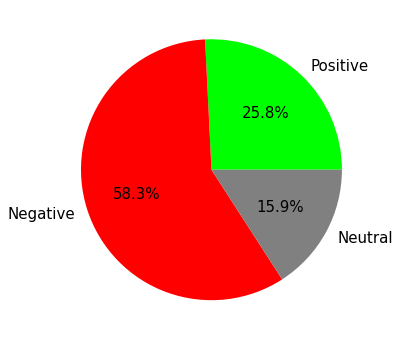

In [ ]:
# Create axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot sentiment
plt.pie([pos_num, neg_num, neu_num], labels=["Positive", "Negative", "Neutral"],
        autopct="%1.1f%%", colors=[GREEN_HEX, RED_HEX, GREY_HEX],
        textprops={"fontsize": 15})

# Show plot
plt.show()

# Ukraine Conflict Twitter Dataset
**Prior Steps Taken**:
1. Extract and Combine all [Ukraine Conflict Twitter Dataset](https://www.kaggle.com/datasets/bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows?resource=download&fbclid=IwAR3l_S5ZgGpOgt9HfD1lTV4PYq8ZKXe5P5vBWJCE6_YgnzLAkFiUAnOFC9w) `.csv` files. *(from 2022-02-24 to 2022-03-28)*
  - > `combined.csv` **7.63GB**
2. Data Cleaning:
  - Drop columns : `["index", "userid", "username", "acctdesc", "following", "totaltweets", "usercreatedts", "tweetid", "hashtags", "coordinates", "favorite_count", "extractedts"]`
  - Keep only `en` english language tweets and rop `language` column
  - Drop duplicates
  - Remove tweets with unkown location
  - > `clean_combined.csv.gz` **167MB**

## Preprocessing
Preprocess `clean_combined.csv` dataset.

In [ ]:
# Load processed tweets
tweets_df = pd.read_csv("clean_combined.csv.gz", parse_dates=["tweetcreatedts"],
                        dtype={"location": "str", "followers": "int", "text": "str"},
                        compression="gzip", quoting=csv.QUOTE_ALL, encoding="utf-8")

# Remove links
tweets_df["text_processed"] = tweets_df["text"].map(lambda x: re.sub(r"http\S+", "", x))

# Remove usernames
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"@[^\s]+", "", x))

# Convert &amp to &
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"&amp;", "&", x))

# Remove &gt and &lt (HTML symbols for '>' and '<')
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"&[gl]t;", "", x))

# Remove punctuation
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"[\.,!?:]", "", x))
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"[=|—#]", " ", x))

# Remove unnecessary line breaks
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"\n", "", x))

# Lowercase text
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: x.lower())

# Remove emoji
emoji_ptrn = re.compile(pattern="["
                        u"\U0001F600-\U0001F64F" # emoticons
                        u"\U0001F300-\U0001F5FF" # symbols & pictographs
                        u"\U0001F680-\U0001F6FF" # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF" # flags
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: emoji_ptrn.sub(r"", x))

# Remove leading, trailing, and replace inner spaces
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub("[\t ]+", " ", x).strip())

# Drop duplicates and keep first occurrence
tweets_df = tweets_df.drop_duplicates(subset=["text_processed"], keep="first")

# Conv to string
tweets_df["text_processed"] = tweets_df["text_processed"].astype(str)

# Remove 's
tweets_df["text_processed"] = tweets_df["text_processed"].map(lambda x: re.sub(r"[‘’']s","",x))

### Sentiment Analysis
Carry out sentiment analysis on `clean_combined.csv.gz` dataset.

In [ ]:
def get_sentiment_label(sentiment, threshold=0.05):
  compound = sentiment["compound"]
  if compound >= threshold:
    return "pos"
  elif compound <= -threshold:
    return "neg"
  else:
    return "neu"

**[Warning]** sentiment analysis for `clean_combined.csv.gz` takes approximately 5 minutes.

In [ ]:
# Sentiment Analysis
analyser = SentimentIntensityAnalyzer()
tweets_df["sentiment"] = tweets_df["text_processed"].apply(lambda tweet: analyser.polarity_scores(tweet))

# Extract sentiment label
tweets_df["sentiment_label"] = tweets_df["sentiment"].apply(lambda sentiment:get_sentiment_label(sentiment))

tweets_df.head()

,location,followers,tweetcreatedts,retweetcount,text,text_processed,sentiment,sentiment_label
0,EU v2.0,267,2022-02-24 06:48:03,1552,A cruise missile fired by the Russian army fel...,a cruise missile fired by the russian army fel...,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",neg
1,Hong Kong,272,2022-02-24 06:48:03,1032,"SPREAD AND SHARE, YOU CAN HELP UKRAINE #Ukrain...",spread and share you can help ukraine ukraine ...,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",pos
2,ホワイトルシアン,1243,2022-02-24 06:48:03,1897,Footage of the airport bombing in Ivano-Franki...,footage of the airport bombing in ivano-franki...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu
3,Omnipresent,13484,2022-02-24 06:48:03,0,"Now this is wrong, absolutely wrong, for @JoeB...",now this is wrong absolutely wrong for and to ...,"{'neg': 0.282, 'neu': 0.718, 'pos': 0.0, 'comp...",neg
4,"St Cloud, MN",1473,2022-02-24 06:48:03,6,🇺🇦 53rd Mechanized Brigade continues to suffer...,53rd mechanized brigade continues to suffer lo...,"{'neg': 0.267, 'neu': 0.733, 'pos': 0.0, 'comp...",neg


In [ ]:
# Group by tweet created date and sentiment label
date_sentiment_df = tweets_df.groupby([pd.Grouper(key="tweetcreatedts", freq="H"),
                                       "sentiment_label"]).agg(
                                           num_tweets=("sentiment_label", "count")
                                           ).reset_index()

# Sentiment line plot
fig = px.line(date_sentiment_df, x="tweetcreatedts", y="num_tweets", 
              color="sentiment_label", color_discrete_sequence=["red", "gray", "green"])
fig.show()

In [ ]:
# Extract compound score
tweets_df["compound"] = tweets_df["sentiment"].apply(lambda sentiment:sentiment["compound"])

# Group by tweet created date
date_sentiment_df = tweets_df.groupby([pd.Grouper(key="tweetcreatedts", freq="H")]).agg(
                                           num_tweets=("sentiment_label", "count"),
                                           avg_compound=("compound", "mean")
                                           ).reset_index()

# Get max and min average compound
max_compound = max(date_sentiment_df["avg_compound"].values)
min_compound = min(date_sentiment_df["avg_compound"].values)

# Normalise average compound
date_sentiment_df["avg_compound_normalised"] = (date_sentiment_df["avg_compound"] - min_compound) / (max_compound - min_compound)

date_sentiment_df.head()

,tweetcreatedts,num_tweets,avg_compound,avg_compound_normalised
0,2022-02-24 06:00:00,377,-0.166664,0.090323
1,2022-02-24 07:00:00,2602,-0.134735,0.168634
2,2022-02-24 08:00:00,2212,-0.123868,0.195289
3,2022-02-24 09:00:00,2038,-0.131479,0.176621
4,2022-02-24 10:00:00,1797,-0.107630,0.235114


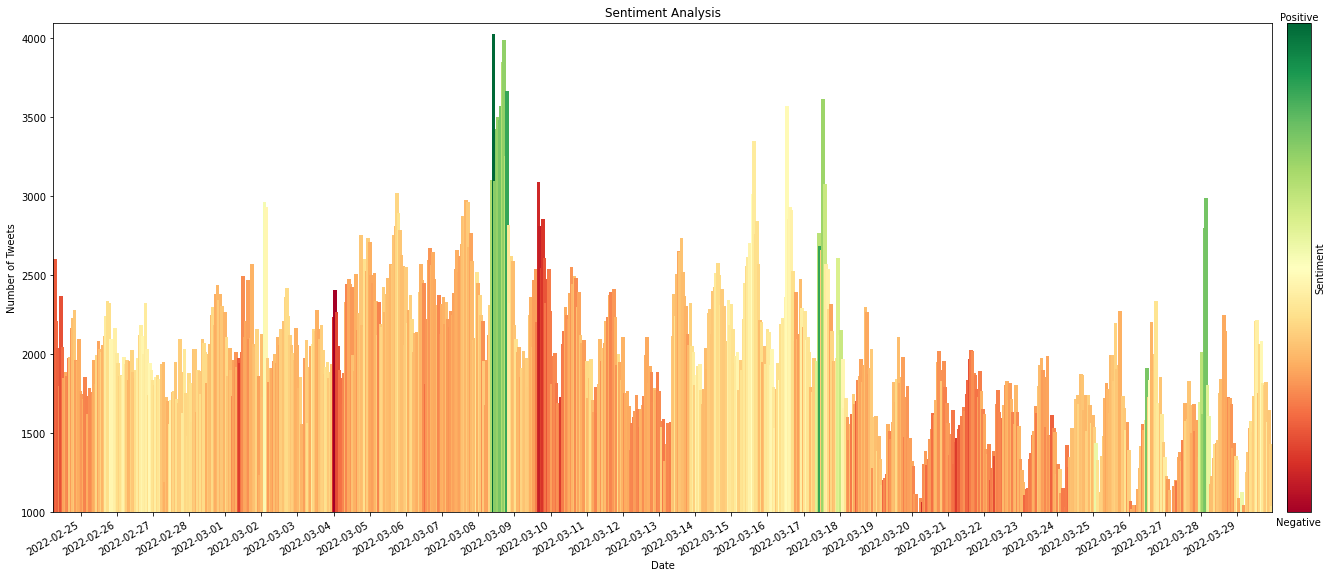

In [ ]:
# Create axis
fig, ax = plt.subplots(figsize=(26, 10))

# Get max and min average normalised compound
max_compound = max(date_sentiment_df["avg_compound_normalised"].values)
min_compound = min(date_sentiment_df["avg_compound_normalised"].values)

# Sentiment bar plot
cmap = plt.cm.get_cmap("RdYlGn")
colours = cmap(date_sentiment_df["avg_compound_normalised"].values)
ax.bar(date_sentiment_df["tweetcreatedts"].values, date_sentiment_df["num_tweets"].values, 
       color=colours, width=0.1)

from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(min_compound, max_compound))
cb = plt.colorbar(sm, ticks=[], pad=0.01)
cb.set_label("Sentiment")
cb.ax.text(0.5, 1.0, "Positive", transform=cb.ax.transAxes, va="bottom", ha="center")
cb.ax.text(0.5, -0.01, "Negative", transform=cb.ax.transAxes, va="top", ha="center")

# Set plot labels
ax.set(xlabel="Date", ylabel="Number of Tweets", title="Sentiment Analysis")

# Set limits
ax.set_ylim([1000, 4100])
ax.set_xlim([date_sentiment_df["tweetcreatedts"].min(), date_sentiment_df["tweetcreatedts"].max()])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
fig.autofmt_xdate()

# Show plot
plt.show()
fig.savefig("sentiment.pdf", bbox_inchest="tight")

### Exploratory Analysis
Build a wordcloud to verify if further preprocessing is necessary.

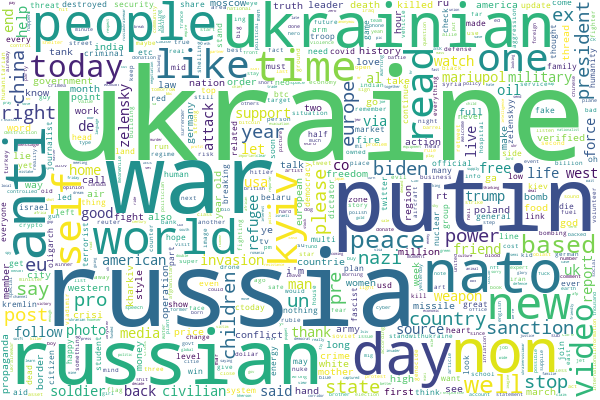

In [ ]:
# Extract Processed tweets
tweets_processed = [str(x) for x in tweets_df["text_processed"]]

# join the words of the different tweets together into one string
long_string = ' '.join(tweets_processed)
new_long_string = ' '.join(set(long_string.split(" ")))

# Stop words
stop_words = stopwords.words("english")
stop_words.extend(["us", "re"])

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=800, contour_width=3, contour_color='steelblue',
                      width=600, height=400, stopwords=stop_words)

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

### Find Countries

In [ ]:
def find_country(loc):
  try:
    # return pycountry.countries.search_fuzzy(loc)[0].name
    return pycountry.countries.get(name=loc).name
  except:
    return np.nan

In [ ]:
# Find country based on location
tweets_df["country"] = tweets_df.apply(lambda row:find_country(row["location"]), axis=1)

# Remove tweets with unknown country
tweets_df = tweets_df.dropna(subset=["country", "text", "text_processed"])

# Save processed tweets as CSV file
tweets_df.to_csv("clean_combined_processed.csv.gz", compression="gzip",
                 quoting=csv.QUOTE_ALL, encoding="utf-8", index=False, header=True)

In [ ]:
tweets_df.head()

,location,followers,tweetcreatedts,retweetcount,text,text_processed,sentiment,sentiment_label,compound,country
1,Hong Kong,272,2022-02-24 06:48:03,1032,"SPREAD AND SHARE, YOU CAN HELP UKRAINE #Ukrain...",spread and share you can help ukraine ukraine ...,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",pos,0.5994,Hong Kong
5,Ukraine,46783,2022-02-24 06:48:04,28,The world must act immediately.- #Ukraine is a...,the world must act immediately- ukraine is at ...,"{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compou...",neg,-0.8516,Ukraine
6,Pakistan,874,2022-02-24 06:48:04,29,The historic moment when the PM of Pakistan Mr...,the historic moment when the pm of pakistan mr...,"{'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'comp...",pos,0.4019,Pakistan
12,Singapore,49,2022-02-24 06:48:05,7,#UPDATE: Russian troops crossing into #Ukraine...,update russian troops crossing into ukraine vi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,0.0000,Singapore
18,Sri Lanka,10,2022-02-24 06:48:06,70,🛑🛑🛑 Video that’s being shared on social media ...,video that being shared on social media showin...,"{'neg': 0.075, 'neu': 0.804, 'pos': 0.121, 'co...",pos,0.2263,Sri Lanka


## Sentiment Analysis

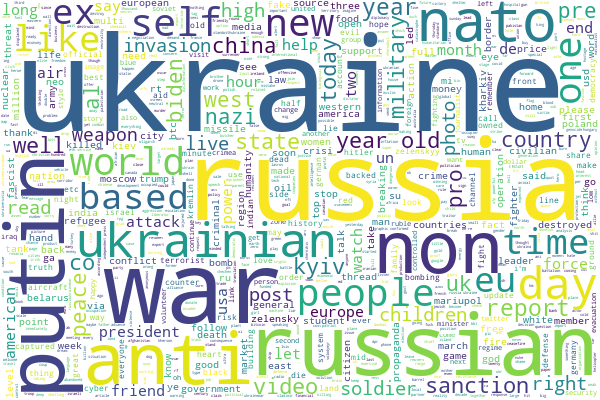

In [ ]:
# Load extracted tweets set
tweets_df = pd.read_csv("clean_combined_processed.csv.gz", parse_dates=["tweetcreatedts"], 
                        dtype={"location": "str", "followers": "int", "text": "str",
                               "text_processed": "str", "country": "str"},
                        compression="gzip", quoting=csv.QUOTE_ALL,
                        encoding="utf-8")

# Extract Processed tweets
tweets_processed = [str(x) for x in tweets_df["text_processed"]]

# join the words of the different tweets together into one string
long_string = ' '.join(tweets_processed)
new_long_string = ' '.join(set(long_string.split(" ")))

# Stop words
stop_words = stopwords.words("english")
stop_words.extend(["us", "re"])

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=800, contour_width=3, contour_color='steelblue',
                      width=600, height=400, stopwords=stop_words)

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

In [ ]:
# Group data by country
country_sentiment_df = tweets_df.groupby(["country"]).agg(
                                          num_tweets=("sentiment_label", "count"),
                                          avg_compound=("compound", "mean")
                                    ).reset_index()

# Set minimum required number of tweets
tweets_threshold = 25
country_sentiment_df = country_sentiment_df.loc[country_sentiment_df["num_tweets"] > tweets_threshold]

# Get max and min average compound
max_compound = max(country_sentiment_df["avg_compound"].values)
min_compound = min(country_sentiment_df["avg_compound"].values)

# Normalise average compound
country_sentiment_df["avg_compound_normalised"] = (country_sentiment_df["avg_compound"] - min_compound) / (max_compound - min_compound)

# Replace country names to match folium geo data
country_sentiment_df["country"] = country_sentiment_df["country"].replace("United States", "United States of America")
country_sentiment_df["country"] = country_sentiment_df["country"].replace("Russian Federation", "Russia")
country_sentiment_df["country"] = country_sentiment_df["country"].replace("Czechia", "Czech Republic")
country_sentiment_df["country"] = country_sentiment_df["country"].replace("Serbia", "Republic of Serbia")
country_sentiment_df["country"] = country_sentiment_df["country"].replace("North Macedonia", "Macedonia")
country_sentiment_df["country"] = country_sentiment_df["country"].replace("Syrian Arab Republic", "Syria")

country_sentiment_df.head()

,country,num_tweets,avg_compound,avg_compound_normalised
0,Afghanistan,342,-0.171994,0.202870
1,Albania,164,-0.084028,0.331914
2,Algeria,197,-0.120798,0.277973
7,Antarctica,420,-0.140157,0.249574
9,Argentina,569,-0.143939,0.244026


In [ ]:
# Choropleth world map
country_shapes = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
map = folium.Map(tiles="cartodbpositron")
folium.Choropleth(
    geo_data=country_shapes,
    name="choropleth",
    data=country_sentiment_df,
    columns=["country", "avg_compound_normalised"],
    key_on="feature.properties.name",
    fill_color="RdYlGn",
    nan_fill_color="grey",
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(map)

# Show map
map.save("map_kaggle.html")
map

# Topic Modelling

In [ ]:
# Load extracted tweets set
tweets_df = pd.read_csv("clean_combined_processed.csv.gz", parse_dates=["tweetcreatedts"], 
                        dtype={"location": "str", "followers": "int", "text": "str",
                               "text_processed": "str", "country": "str"},
                        compression="gzip", quoting=csv.QUOTE_ALL,
                        encoding="utf-8")

# Define Stopwords words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use',
                   "russia", "ukraine"])

# Preprocessing
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]

# Extract processed text as a list of words
data_words = list(sent_to_words(tweets_df["text_processed"].values.tolist()))

# Remove stop words
data_words = remove_stopwords(data_words)

# Create dictionary
id2word = corpora.Dictionary(data_words)

# Create corpus
texts = data_words

# BoW representation of corpus
corpus = [id2word.doc2bow(text) for text in texts]

## Hyperparameter Tuning
Find optimnal number of topics by computing and comparing coherence score.

In [ ]:
coherence_list = []
num_topic_list = []
for i in range(2, 16):
  # Build LDA model
  lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=i, random_state=1)
  num_topic_list.append(i)

  # Compute coherence score
  coherence_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence="c_v")
  coherence = coherence_lda.get_coherence()
  coherence_list.append(coherence)
  print(f"Topic #{i} : coh={coherence}")

Topic #2 : coh=0.3389637097392382
Topic #3 : coh=0.30292933893018964
Topic #4 : coh=0.327646824897768
Topic #5 : coh=0.3469197225803722
Topic #6 : coh=0.41175598413191256
Topic #7 : coh=0.37763908817037667
Topic #8 : coh=0.3977781813164839
Topic #9 : coh=0.4167403613950126
Topic #10 : coh=0.38441348584302537
Topic #11 : coh=0.42021109017183494
Topic #12 : coh=0.41305333129808336
Topic #13 : coh=0.3648320396095585
Topic #14 : coh=0.3915602066212255
Topic #15 : coh=0.41882730986423844


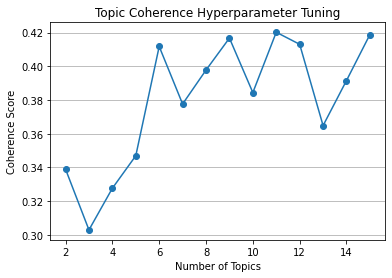

In [ ]:
# Create axis    
fig, ax = plt.subplots()

# Plot topic coherence
ax.plot(num_topic_list, coherence_list, marker="o")
ax.set(xlabel="Number of Topics", ylabel="Coherence Score",
       title="Topic Coherence Hyperparameter Tuning")

# Show plots
ax.yaxis.grid()
plt.show()
# fig.savefig("topic_coherence.pdf", bbox_inchest="tight")

## Topic Exploratory Analysis

In [ ]:
# Build LDA model with optimal number of topics
optimal_number_of_topics = 6
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word,
                                       num_topics=optimal_number_of_topics, random_state=1)

# Print keywords in topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"putin" + 0.013*"slavaukraini" + 0.011*"people" + 0.009*"like" + '
  '0.009*"oscars" + 0.008*"stoprussia" + 0.008*"russian" + 0.007*"one" + '
  '0.006*"war" + 0.005*"know"'),
 (1,
  '0.027*"war" + 0.017*"nato" + 0.015*"putin" + 0.010*"world" + 0.009*"people" '
  '+ 0.008*"us" + 0.008*"stop" + 0.006*"country" + 0.006*"usa" + 0.005*"must"'),
 (2,
  '0.012*"nft" + 0.011*"support" + 0.009*"war" + 0.009*"help" + '
  '0.009*"ukrainewar" + 0.007*"crypto" + 0.007*"peace" + 0.005*"please" + '
  '0.005*"nfts" + 0.005*"nftcommunity"'),
 (3,
  '0.061*"russian" + 0.024*"ukrainian" + 0.016*"kyiv" + 0.015*"forces" + '
  '0.014*"military" + 0.013*"ukrainewar" + 0.011*"mariupol" + 0.010*"city" + '
  '0.009*"region" + 0.009*"army"'),
 (4,
  '0.018*"war" + 0.017*"russian" + 0.016*"mariupol" + 0.015*"ukrainewar" + '
  '0.015*"ukrainian" + 0.015*"stoprussia" + 0.010*"kyiv" + 0.009*"people" + '
  '0.009*"children" + 0.009*"poland"'),
 (5,
  '0.034*"putin" + 0.021*"biden" + 0.014*"president" + 


Topic : 0


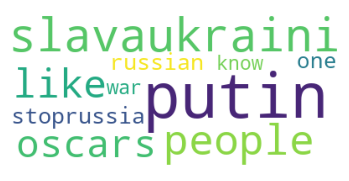


Topic : 1


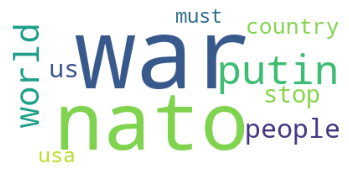


Topic : 2


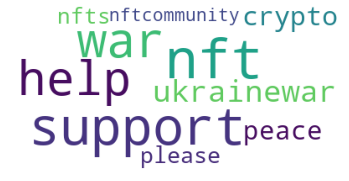


Topic : 3


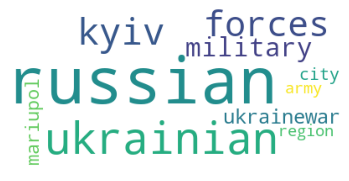


Topic : 4


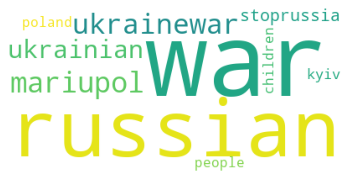


Topic : 5


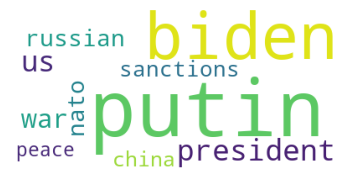

In [ ]:
# Show word cloud for each topic
topn = 10
for i in range(optimal_number_of_topics):
  # create a WordCloud object
  wordcloud = WordCloud(background_color="white", contour_width=3, contour_color='steelblue')

  # generate a word cloud
  wordcloud.fit_words(dict(lda_model.show_topic(i, topn=topn)))

  # visualize the word cloud
  print(f"\nTopic : {i}")
  plt.axis("off")
  plt.imshow(wordcloud)
  # wordcloud.to_image()
  plt.show()

## Visualise Topics

In [ ]:
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualise topics
pyLDAvis.enable_notebook()

# Prep visualisation
LDAvis_data_filepath = os.path.join('./'+str(optimal_number_of_topics))
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

# Load prepared data
with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

# Save visualisation and display it
pyLDAvis.save_html(LDAvis_prepared, './'+ str(optimal_number_of_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.158583  0.076444       1        1  21.321836
5     -0.105542  0.216391       2        1  19.275576
0     -0.122967 -0.032690       3        1  19.099909
3      0.279484  0.076333       4        1  15.192231
4      0.227351 -0.088401       5        1  13.706982
2     -0.119743 -0.248078       6        1  11.403467, topic_info=           Term          Freq         Total Category  logprob  loglift
36      russian  38502.000000  38502.000000  Default  30.0000  30.0000
137       biden  10583.000000  10583.000000  Default  29.0000  29.0000
35        putin  33458.000000  33458.000000  Default  28.0000  28.0000
134    mariupol  10096.000000  10096.000000  Default  27.0000  27.0000
83    ukrainian  18073.000000  18073.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
47          via   1017.313612   3841.284027   Topic6  -5.6609   0.8426
83    ukrainian   1245.104573  18073.908110   Topic6  -5.4588  -0.5040
21        world   1130.561656  10248.255519   Topic6  -5.5554  -0.0331
445        like    974.851662   7425.904630   Topic6  -5.7035   0.1408
1014        day    913.548271   4770.440980   Topic6  -5.7685   0.5184

[483 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2987      1  0.001998  abandoned
2987      3  0.007994  abandoned
2987      5  0.989212  abandoned
1599      1  0.005656  according
1599      2  0.061185  according
...     ...       ...        ...
2433      4  0.078336  zelenskyy
2433      5  0.000757  zelenskyy
2433      6  0.001135  zelenskyy
2129      1  0.998337       zero
4235      5  0.997980    украіна

[1157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 4, 5, 3])

# Named Entity Recognition


This implementation is based on [spaCy's model](https://spacy.io/models/en#en_core_web_trf) using contextualised embeddings.

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')

**NOTE:** Reduce `N_tweets` number of tweets to reduce time taken for NER.

In [ ]:
# Load extracted tweets set
tweets_df = pd.read_csv("clean_combined_processed.csv.gz", parse_dates=["tweetcreatedts"], 
                        dtype={"location": "str", "followers": "int", "text": "str",
                               "text_processed": "str", "country": "str"},
                        compression="gzip", quoting=csv.QUOTE_ALL,
                        encoding="utf-8")

# Extract Processed tweets
tweets_processed = [str(x) for x in tweets_df["text_processed"]]

# Randomly select tweets
N_tweets = 10000
tweets = np.random.choice(tweets_processed, N_tweets, replace=False).tolist()
tweets_nr = len(tweets)

# Extract entities
entities_nr = 0
entities_count = {}
for i, tweet_text in enumerate(tweets):
  print(f"({i}/{tweets_nr}){tweet_text}")
  
  # Get entities
  doc = nlp(tweet_text)
  for ne in doc.ents:
    entities_nr += 1
    entity_name = tweet_text[ne.start_char:ne.end_char]
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, entity_name)

    entities_count[entity_name] = {"count": entities_count.get(entity_name, {"count": 0})["count"] + 1, "label":ne.label_}

In [ ]:
# Store entities into datafarme
entities_df = pd.DataFrame.from_dict(entities_count, orient="index")

# Sort and display top entities
entities_df = entities_df.sort_values(by=["count"], ascending=False)

# Filter entity labels
print(entities_df.loc[entities_df["label"] == "GPE"][:15], "\n")
print(entities_df.loc[entities_df["label"] == "PERSON"][:15])